In [ ]:
import sys, os
import numpy as np
import matplotlib.pyplot as plt
from dask_quantumtinkerer import Cluster, cluster_options
import adaptive

from collections import OrderedDict
from scipy.optimize import minimize_scalar
from functools import partial

from codes.parameters import phase_pairs, junction_parameters, pair_voltages
from codes.optimization import phase_loss
from codes.utils import eigsh
from codes.trijunction_matrices import make_system
from codes.system_functions import diagonalisation, adaptive_two_parameters

In [ ]:
from importlib import reload

# Adaptive exploration of voltage space

In this notebook we explore the voltage dependence of the Majorana coupling in a trijunction.
The setup is defined in `config`.
It contains details about:
1. Material parameters.
2. Device geometry parameters.
3. Nanowire geometry parameters for `kwant`.


## Build system

In [14]:
zero_potential, trijunction, f_params, linear_terms = make_system()

Finding closed voronoi cells
Done selecting closed voronoi cells
Calculating points distance
Done
Calculating ridges hypersurfaces
Done
Finding  hypervolume for closed voronoi cells
Done finding hypervolume for closed voronoi cells
Done calculating surface
Done calculating distance
Done calculating capacitance matrix


100%|██████████| 13/13 [00:19<00:00,  1.53s/it]


In [15]:
pairs = ['right-top', 'left-top', 'left-right']

In [16]:
params = junction_parameters()
params.update(potential=zero_potential)

In [17]:
kwant_params = trijunction, f_params, linear_terms

In [18]:
def pair_voltages(initial=[-1.5e-3, -1.5e-3, -1.5e-3, 8e-3], depleted=-3.5e-3):
    """
    
    """
    pairs = ['right-top', 'left-top', 'left-right']
    voltages = OrderedDict()
    initial_condition = OrderedDict()

    for i, pair in enumerate(pairs):
        initial[i] = depleted
        voltages[pair] = voltage_dict(initial, True)
        initial_condition[pair] = initial.copy()

    return voltages

In [19]:
import codes.parameters
reload(codes.parameters)

<module 'codes.parameters' from '/home/tinkerer/trijunction-design/analysis/codes/parameters.py'>

In [20]:
voltages = codes.parameters.pair_voltages()

In [22]:
voltages[pairs[0]]

{'left_1': -0.0035,
 'left_2': -0.0035,
 'right_1': -0.0015,
 'right_2': -0.0015,
 'top_1': -0.0015,
 'top_2': -0.0015,
 'global_accumul': 0.008,
 'dirichlet_0': 0.0,
 'dirichlet_1': 0.0,
 'dirichlet_2': 0.0,
 'dirichlet_3': 0.0,
 'dirichlet_4': 0.0,
 'dirichlet_5': 0.0}

## Phase tunning

### Optimisation using `scipy`

In [7]:
%%time

scipy_phases = {}
kwant_params

for pair in pairs:
    argv_phase = [pair, voltages[pair]]+list(kwant_params.values())

    sol = minimize_scalar(
            phase_loss,
            args=tuple(argv_phase),
            bounds=(0, 2), 
            method='bounded'
        )

    scipy_phases[pair] = phase_pairs(pair, np.pi * sol.x)

NameError: name 'kwant_params' is not defined

In [7]:
scipy_phases

{'right-top': {'phi2': 5.071483786280952, 'phi1': 0},
 'left-top': {'phi2': 1.2117015209626474, 'phi1': 0},
 'left-right': {'phi1': 0.905582702754955, 'phi2': 0}}

### Uniform grid sampling

In [23]:
options = cluster_options()
options.worker_cores = 2
options.worker_memory = 2
options.extra_path = "/home/jtorresluna/trijunction-design/"

In [24]:
reload(codes.parameters)

<module 'codes.parameters' from '/home/tinkerer/trijunction-design/analysis/codes/parameters.py'>

In [25]:
# prepare arguments
phis = np.linspace(0, 2, 50) * np.pi
phases = {}

for pair in pairs:
    phases[pair] = [codes.parameters.phase_pairs(pair, phi) for phi in phis]

In [26]:
from importlib import reload
import codes.system_functions


In [27]:
cluster = Cluster(options)
cluster.scale(50)
client = cluster.get_client()
client.wait_for_workers(1)
print("http://io.quantumtinkerer.tudelft.nl/user/jdtorres/proxy/"+cluster.dashboard_link[17:])

http://io.quantumtinkerer.tudelft.nl/user/jdtorres/proxy/8000/clusters/5fda922ff29c4ff6b70672395afaeeac/status


Exception in callback None()
handle: <Handle cancelled>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/tornado/iostream.py", line 1391, in _do_ssl_handshake
    self.socket.do_handshake()
  File "/opt/conda/lib/python3.10/ssl.py", line 1342, in do_handshake
    self._sslobj.do_handshake()
ssl.SSLEOFError: EOF occurred in violation of protocol (_ssl.c:997)

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/asyncio/events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "/opt/conda/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 189, in _handle_events
    handler_func(fileobj, events)
  File "/opt/conda/lib/python3.10/site-packages/tornado/iostream.py", line 696, in _handle_events
    self._handle_read()
  File "/opt/conda/lib/python3.10/site-packages/tornado/iostream.py", line 1478, in _handle_read
    self._do_ssl_han

In [62]:
params.update(potential=zero_potential)

In [71]:
codes.system_functions.diagonalisation({}, kwant_params, voltages[pair], params)

array([-3.26121571e-04, -3.17444716e-04, -2.91148951e-04, -2.61229539e-04,
       -1.99253248e-04, -1.70087678e-04, -9.62537990e-05, -4.42933790e-05,
       -1.56872901e-07, -2.04740542e-11,  2.04740545e-11,  1.56872901e-07,
        4.42933790e-05,  9.62537990e-05,  1.70087678e-04,  1.99253248e-04,
        2.61229539e-04,  2.91148951e-04,  3.17444716e-04,  3.26121571e-04])

In [72]:
%%time
phase_relations = {}

kwant_params_scattered = client.scatter(kwant_params, broadcast=True)

for pair in pairs:
    futures = client.map(
        codes.system_functions.diagonalisation,
        phases[pair],
        kwant_params=kwant_params_scattered,
        voltages=voltages[pair],
        params=params
    )
    phase_relations[pair] = client.gather(futures)

CPU times: user 58.8 s, sys: 6.6 s, total: 1min 5s
Wall time: 1min 48s


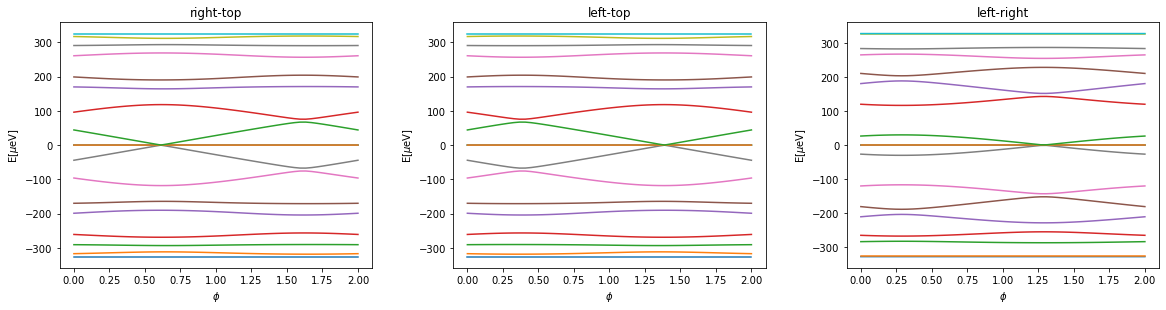

In [73]:
fig, axes = plt.subplots(ncols=3, figsize=(16, 4))
fig.tight_layout(w_pad=5)

for i, pair in enumerate(pairs):

    phase = 1e6*np.array(phase_relations[pair])

    axes[i].set_title(pair)
    axes[i].set_xlabel(r'$\phi$')
    axes[i].set_ylabel(r'E[$\mu$eV]')

    axes[i].plot(phis/np.pi, phase)
    #opt_phase = list(scipy_phases[pair].values())[0]/np.pi
    #axes[i].vlines(opt_phase, ymin=-np.max(phase), ymax=np.max(phase))

## Majorana coupling in voltage space

In [72]:
plunger_min = -5e-3
plunger_max = 5e-3

bounds = [
    (plunger_min, plunger_max),
    (plunger_min, plunger_max),
]

gates = ['left','top','accum']

In [73]:
reload(codes.system_functions)

<module 'codes.system_functions' from '/home/tinkerer/trijunction-design/analysis/codes/system_functions.py'>

In [74]:
f = partial(
        codes.system_functions.adaptive_two_parameters,
        voltages=voltages[pairs[0]],
        params=params,
        gates=gates
        )

In [75]:
f((0,1))

3.257168291626822e-06

In [76]:
learner = adaptive.Learner2D(f, bounds=bounds)
runner = adaptive.BlockingRunner(
    learner,
    goal=lambda l: l.loss() < 0.01,
    executor=client
)

In [78]:
_, _, z = learner.interpolated_on_grid()

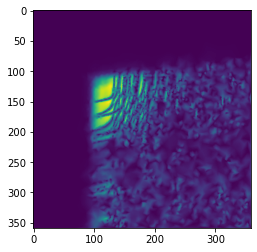

Exception in callback None()
handle: <Handle cancelled>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/tornado/iostream.py", line 1391, in _do_ssl_handshake
    self.socket.do_handshake()
  File "/opt/conda/lib/python3.10/ssl.py", line 1342, in do_handshake
    self._sslobj.do_handshake()
ssl.SSLEOFError: EOF occurred in violation of protocol (_ssl.c:997)

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/asyncio/events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "/opt/conda/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 189, in _handle_events
    handler_func(fileobj, events)
  File "/opt/conda/lib/python3.10/site-packages/tornado/iostream.py", line 696, in _handle_events
    self._handle_read()
  File "/opt/conda/lib/python3.10/site-packages/tornado/iostream.py", line 1478, in _handle_read
    self._do_ssl_han

In [79]:
plt.imshow(z)

In [88]:
with Cluster(options) as cluster:
    cluster.scale(25)
    client = cluster.get_client()
    client.wait_for_workers(1)
    print("http://io.quantumtinkerer.tudelft.nl/user/jdtorres/proxy/"+cluster.dashboard_link[17:])

    data_pairs = {}

    for pair in pairs:
        print(pair)

        gates = tuple(pair.split('-'))
        params.update(scipy_phases[pair])

        f = partial(
            codes.system_functions.adaptive_two_parameters,
            voltages=voltages[pair],
            params=params,
            gates=gates
        )

        learner = adaptive.Learner2D(f, bounds=bounds)
        runner = adaptive.BlockingRunner(
            learner,
            goal=lambda l: l.loss() < 0.01,
            executor=client
        )

        _, _, z = learner.interpolated_on_grid()
        data_pairs[pair] = z


http://io.quantumtinkerer.tudelft.nl/user/jdtorres/proxy/8000/clusters/c1a25920b2aa4d7f95b3c64b4d370990/status
right-top


RuntimeError: An error occured while evaluating "learner.function((-0.005, -0.005))". See the traceback for details.:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/adaptive/runner.py", line 218, in _process_futures
    y = fut.result()
  File "/opt/conda/lib/python3.10/concurrent/futures/_base.py", line 439, in result
    return self.__get_result()
  File "/opt/conda/lib/python3.10/concurrent/futures/_base.py", line 391, in __get_result
    raise self._exception
  File "/opt/conda/lib/python3.10/site-packages/distributed/cfexecutor.py", line 32, in _cascade_future
    raise exc.with_traceback(tb)
TypeError: adaptive_two_parameters() got an unexpected keyword argument 'params'


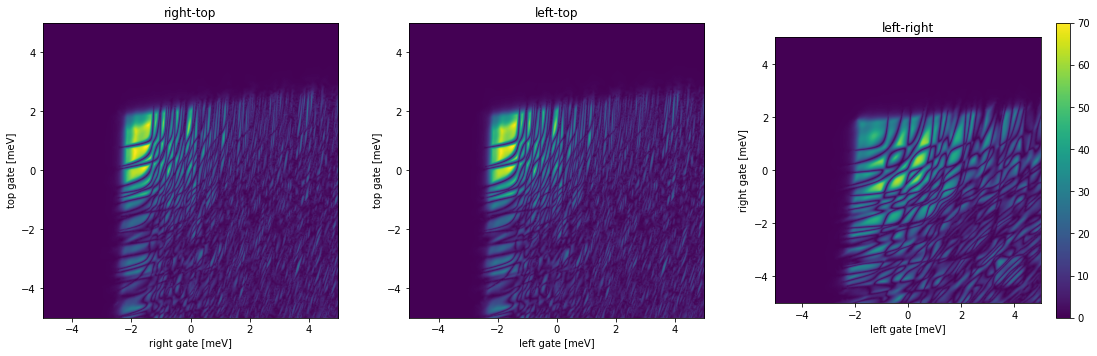

In [107]:
fig, ax = plt.subplots(ncols=3, figsize=(15, 5))
fig.tight_layout(w_pad=4)
for i, pair in enumerate(pairs):
    gates = tuple(pair.split('-'))
    ax[i].set_title(pair)
    plot = ax[i].imshow(
        1e6*data_pairs[pair],
        extent=(1e3*plunger_min, 1e3*plunger_max, 1e3*plunger_min, 1e3*plunger_max),
        vmin=0, vmax=70
    )
    ax[i].set_xlabel(gates[0]+' gate [meV]')
    ax[i].set_ylabel(gates[1]+' gate [meV]')
plt.colorbar(plot, fraction=0.05, pad=0.05)


## Async execution of adaptive

In [1]:
options = cluster_options()
options.worker_cores = 2
options.worker_memory = 2
options.extra_path = "/home/jtorresluna/trijunction-design/"

NameError: name 'cluster_options' is not defined

In [25]:
import codes.parameters

In [66]:
pair = pairs[0]

gates = tuple(pair.split('-'))
params = codes.parameters.junction_parameters()
params.update(potential=zero_potential)

In [67]:
plunger_min = -5e-3
plunger_max = 5e-3

bounds = [
    (plunger_min, plunger_max),
    (plunger_min, plunger_max),
]

In [74]:
cluster = Cluster(options)
cluster.scale(20)
client = cluster.get_client()
client.wait_for_workers(1)
print("http://io.quantumtinkerer.tudelft.nl/user/jdtorres/proxy/"+cluster.dashboard_link[17:])

http://io.quantumtinkerer.tudelft.nl/user/jdtorres/proxy/8000/clusters/b1d1e67e10ee4e439505763bf2f1e953/status


In [75]:
scattered_system = client.scatter(kwant_params, broadcast=True)

In [76]:
async def f_async(xy):
    future = client.submit(
        adaptive_two_parameters,
        xy,
        voltages=voltages[pair],
        kwant_params=scattered_system,
        gates=gates,
        params=params
    )
    result = await client.gather(future, asynchronous=True)
    return result

In [77]:
learner = adaptive.Learner2D(f_async, bounds=bounds)

In [78]:
runner = adaptive.AsyncRunner(
    learner,
    goal=lambda l: l.loss() < 0.001,
    ntasks=20
)

Task exception was never retrieved
future: <Task finished name='Task-4454' coro=<AsyncRunner._run() done, defined at /opt/conda/lib/python3.10/site-packages/adaptive/runner.py:635> exception=RuntimeError('An error occured while evaluating "learner.function((-0.001680101836328021, -0.0012340316234539673))". See the traceback for details.:\n\nTraceback (most recent call last):\n  File "/opt/conda/lib/python3.10/site-packages/distributed/comm/tcp.py", line 233, in read\n    n = await stream.read_into(chunk)\n  File "/opt/conda/lib/python3.10/site-packages/tornado/iostream.py", line 475, in read_into\n    self._try_inline_read()\n  File "/opt/conda/lib/python3.10/site-packages/tornado/iostream.py", line 841, in _try_inline_read\n    self._check_closed()\n  File "/opt/conda/lib/python3.10/site-packages/tornado/iostream.py", line 1017, in _check_closed\n    raise StreamClosedError(real_error=self.error)\ntornado.iostream.StreamClosedError: Stream is closed\n\nThe above exception was the dire

In [81]:
runner.status()

'running'

Exception in callback None()
handle: <Handle cancelled>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/tornado/iostream.py", line 1391, in _do_ssl_handshake
    self.socket.do_handshake()
  File "/opt/conda/lib/python3.10/ssl.py", line 1342, in do_handshake
    self._sslobj.do_handshake()
ssl.SSLEOFError: EOF occurred in violation of protocol (_ssl.c:997)

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/asyncio/events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "/opt/conda/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 189, in _handle_events
    handler_func(fileobj, events)
  File "/opt/conda/lib/python3.10/site-packages/tornado/iostream.py", line 696, in _handle_events
    self._handle_read()
  File "/opt/conda/lib/python3.10/site-packages/tornado/iostream.py", line 1478, in _handle_read
    self._do_ssl_han

In [62]:
runner.pending_points

[(<Task cancelled name='Task-3345' coro=<f_async() done, defined at /tmp/ipykernel_1235/4077183641.py:1>>,
  (-0.005, -0.005)),
 (<Task cancelled name='Task-3346' coro=<f_async() done, defined at /tmp/ipykernel_1235/4077183641.py:1>>,
  (-0.005, 0.005)),
 (<Task cancelled name='Task-3347' coro=<f_async() done, defined at /tmp/ipykernel_1235/4077183641.py:1>>,
  (0.005, -0.005)),
 (<Task cancelled name='Task-3348' coro=<f_async() done, defined at /tmp/ipykernel_1235/4077183641.py:1>>,
  (0.005, 0.005)),
 (<Task cancelled name='Task-3349' coro=<f_async() done, defined at /tmp/ipykernel_1235/4077183641.py:1>>,
  (0.0016666666666666666, 0.0016666666666666666)),
 (<Task cancelled name='Task-3350' coro=<f_async() done, defined at /tmp/ipykernel_1235/4077183641.py:1>>,
  (-0.0016666666666666666, -0.0016666666666666666)),
 (<Task cancelled name='Task-3351' coro=<f_async() done, defined at /tmp/ipykernel_1235/4077183641.py:1>>,
  (-0.0038888888888888883, -0.0005555555555555554)),
 (<Task cancel

In [65]:
runner.task.result()

CancelledError: 

Exception in callback None()
handle: <Handle cancelled>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/tornado/iostream.py", line 1391, in _do_ssl_handshake
    self.socket.do_handshake()
  File "/opt/conda/lib/python3.10/ssl.py", line 1342, in do_handshake
    self._sslobj.do_handshake()
ssl.SSLEOFError: EOF occurred in violation of protocol (_ssl.c:997)

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/asyncio/events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "/opt/conda/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 189, in _handle_events
    handler_func(fileobj, events)
  File "/opt/conda/lib/python3.10/site-packages/tornado/iostream.py", line 696, in _handle_events
    self._handle_read()
  File "/opt/conda/lib/python3.10/site-packages/tornado/iostream.py", line 1478, in _handle_read
    self._do_ssl_han